In [1]:
import scniche as sn
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Last run with scNiche version:", sn.__version__)

# set seed
sn.pp.set_seed()

/slurm/home/yrd/fanlab/qianjingyang/.conda/envs/scniche_v101/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Last run with scNiche version: 1.1.0


In [2]:
# download data from https://zenodo.org/records/10362607, Dataset 9
adata_rna = sc.read('data/adata_RNA.h5ad')
adata_cuttag = sc.read('data/adata_peaks_normalized.h5ad')

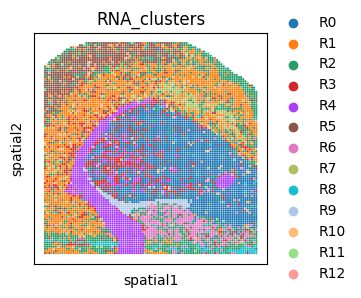

In [3]:
# cluster provided by original authors, RNA
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata_rna, basis="spatial", color=['RNA_clusters'],s=10, )

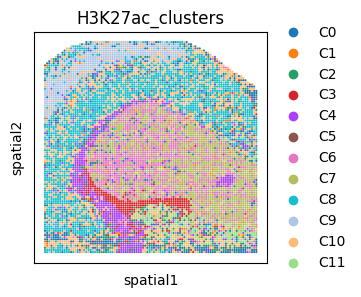

In [4]:
# cluster provided by original authors, H3K27ac
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata_cuttag, basis="spatial", color=['H3K27ac_clusters'],s=10, )

In [5]:
# scNiche
# extrcat data_nbr
cutoff = 30
adata_rna = sn.pp.cal_spatial_exp(adata=adata_rna, mode='KNN', k_cutoff=cutoff, is_pca=False, verbose=False, layer_key='X_pca')
adata_cuttag = sn.pp.cal_spatial_exp(adata=adata_cuttag, mode='KNN', k_cutoff=cutoff, is_pca=False, verbose=False, layer_key='X_lsi')

# new AnnData
adata = sc.AnnData(adata_rna.X.copy())
adata.obs = adata_rna.obs.copy()
adata.obsm['X_rna'] = adata_rna.obsm['X_data'].copy()
adata.obsm['X_rna_nbr'] = adata_rna.obsm['X_data_nbr'].copy()
adata.obsm['X_cuttag'] = adata_cuttag.obsm['X_data'].copy()
adata.obsm['X_cuttag_nbr'] = adata_cuttag.obsm['X_data_nbr'].copy()
adata.obsm['spatial'] = adata_rna.obsm['spatial'].copy()
adata

AnnData object with n_obs × n_vars = 9370 × 23415
    obs: 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'nCount_H3K27ac', 'nFeature_H3K27ac', 'nCount_peaks', 'nFeature_peaks', 'RNA_clusters', 'H3K27ac_clusters'
    obsm: 'X_rna', 'X_rna_nbr', 'X_cuttag', 'X_cuttag_nbr', 'spatial'

In [6]:
lr = 0.01
epochs = 100

# prepare
choose_views = ['X_rna', 'X_rna_nbr', 'X_cuttag', 'X_cuttag_nbr']
adata = sn.pp.prepare_data(adata=adata, verbose=True, choose_views=choose_views)
                
# training
model = sn.tr.Runner(adata=adata, device='cuda:0', verbose=True, choose_views=choose_views)
adata = model.fit(lr=lr, epochs=epochs)

-------Constructing graph for each view...
Constructing done.
-------Prepare training...
Views: 4
View-0: X_rna, DataSize: 9370 * 50; Graph Edges: 347030
View-1: X_rna_nbr, DataSize: 9370 * 50; Graph Edges: 231308
View-2: X_cuttag, DataSize: 9370 * 50; Graph Edges: 377264
View-3: X_cuttag_nbr, DataSize: 9370 * 50; Graph Edges: 236168
Mutual Information Matrix Size for training: (9370, 20)
-------Start training...


Train Epoch: 100: 100%|██████████| 100/100 [02:19<00:00,  1.40s/it, loss=28.7203]


Training done.


Applying K-Means Clustering with 12 target cluster numbers...


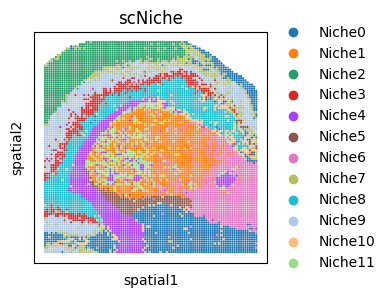

In [7]:
# clustering
target_num = 12
adata = sn.tr.clustering(adata=adata, target_k=target_num)
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis="spatial", color=['scNiche', ],s=10, )